<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting UVI with LSTMs

[Notebook 0: Data Cleaning](./0_DataCleaning.ipynb)

[Notebook 1: EDA](./1_EDA.ipynb)

[Notebook 2: Modeling and Predictions](./2_Modeling_and_Predictions.ipynb)

[Notebook 3: Technical Report](./3_Technical_Report.ipynb)

Was wird in diesem Notebook gemacht?

## Verbinden mit der Google Drive und Import der benötigten Module:

In [1]:
# Verbinden mit der Google-Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## import modules

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime
from datetime import timedelta

import matplotlib
import seaborn as sns

In [3]:
latitude = 50.2
longitude = 7.8

seconds_in_day = 24*60*60
seconds_in_year = (365.2425)*seconds_in_day

In [4]:
# Pfad zur CSV-Datei auf Google Drive
name_Messwerte = 'Messdaten.csv'
name_Vorhersage = 'Vorhersage.csv'
drive_path = '/content/drive/My Drive/Colab_Notebooks/Clean_Data/'
output_plot_path = '/content/drive/My Drive/Colab_Notebooks/plot_daily_UVI/'

In [5]:
# Import der Daten für die EDA
df_UVI = pd.read_csv(drive_path + name_Messwerte)
df_CAMS = pd.read_csv(drive_path + name_Vorhersage)

# Messzeitpunkt in Datetime umwandeln
df_UVI.set_index('Datetime', inplace=True)
df_CAMS.set_index('Datetime', inplace=True)

df_UVI.index = pd.to_datetime(df_UVI.index)
df_CAMS.index = pd.to_datetime(df_CAMS.index)

In [57]:
Stündlicher Durchschitt ohne
df_UVI_hourly = df_UVI[df_UVI['UVI'] != 0][['UVI','erythem', 'SolarZenithAngle']].resample('H').mean()

In [59]:
# Stündlicher Durchschitt mit Nullen
df_UVI_hourly_withZero = df_UVI[['UVI','erythem', 'SolarZenithAngle']].resample('H').mean()

## Plotten der Dataframes:

### Plot der Tagesdurchschnitte:

In [8]:
def plot_daily_mean_data(df1, df2, value_column1='UVI', value_column2='Wert2'):

    # Resample auf tägliche Auflösung und Berechnung des Durchschnitts
    df1_daily = df1.resample('D').mean()
    df2_daily = df2.resample('D').mean()

    # Erstellen Sie den Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df1_daily.index, df1_daily[value_column1], label='DataFrame 1', marker='o')
    plt.plot(df2_daily.index, df2_daily[value_column2], label='DataFrame 2', marker='x')

    plt.title('Tägliche Messwerte')
    plt.xlabel('Datum')
    plt.ylabel('Durchschnittlicher Messwert')
    plt.legend()
    plt.grid(True)

    # Rotieren Sie die X-Achsenbeschriftungen für bessere Lesbarkeit
    plt.xticks(rotation=45)

    # Zeigen Sie den Plot an
    plt.tight_layout()
    plt.show()

<ipython-input-8-8b9276a4edb2>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1_daily = df1.resample('D').mean()


KeyError: ignored

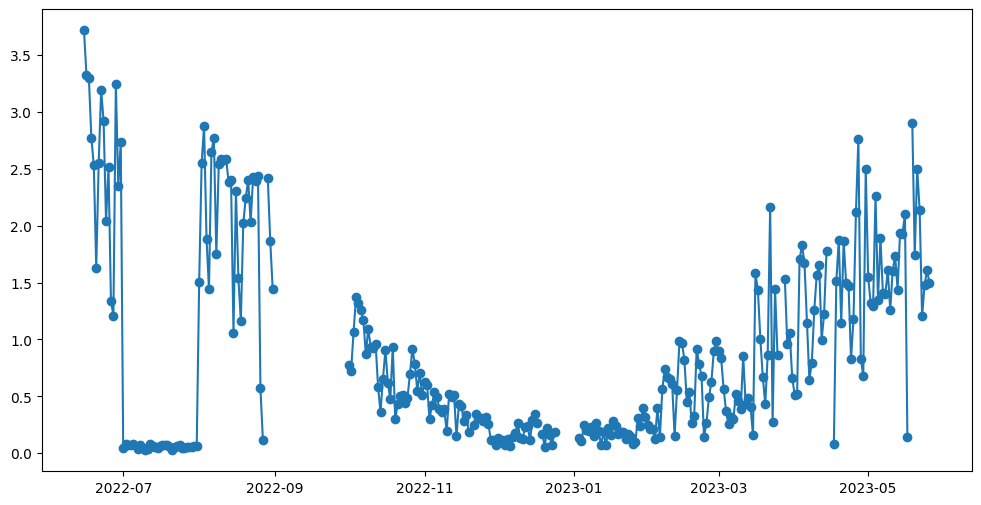

In [9]:
plot_daily_mean_data(df_UVI, df_CAMS)

### Plot der täglichen Verläufe:

In [12]:
df_plot_daily = pd.concat([df_UVI[['UVI', 'SolarZenithAngle']], df_CAMS[['aod469', 'uvbed', 'uvbedcs', 'tcc']]], axis = 1)

In [44]:
def create_daily_plots(df, columns_to_plot):
    # Gruppieren nach Tag
    grouped = df.groupby(df.index.date)

    # Stil für Seaborn-Plots festlegen
    sns.set(style="darkgrid")

    for date, group in grouped:
        fig, ax1 = plt.subplots(figsize=(10, 6))  # Hauptfigur und erste Achse erstellen

        twin1 = ax1.twinx()
        twin2 = ax1.twinx()
        twin3 = ax1.twinx()
        twin4 = ax1.twinx()

        twin1.spines.right.set_position(("axes", 1))
        twin2.spines.right.set_position(("axes", 1.1))
        twin3.spines.right.set_position(("axes", 1.22))
        twin4.spines.right.set_position(("axes", 1.33))

        # Erste Achse erstellen (links)
        sns.set(style="whitegrid")

        # # Zweiter Plot mit Seaborn auf der zweiten Y-Achse
        sns.lineplot(data=df, x=df.index, y='UVI', label='UVI', marker='o', color='b', ax=ax1)

        sns.lineplot(data=df, x=df.index, y='SolarZenithAngle', label='SZA', marker='o', color='r', ax=twin1)

        sns.lineplot(data=df, x=df.index, y='uvbed', label='UVI', marker='o', color='g', ax=twin2)

        sns.lineplot(data=df, x=df.index, y='uvbedcs', label='UVI CS', marker='o', color='k', ax=twin3)

        sns.lineplot(data=df, x=df.index, y='tcc', label='TCC', marker='o', color='y', ax=twin4)

        plt.xlabel('Uhrzeit')
        plt.legend(loc='upper left')
        plt.title(f'Tagesverlauf für den {date}')
        plt.show()

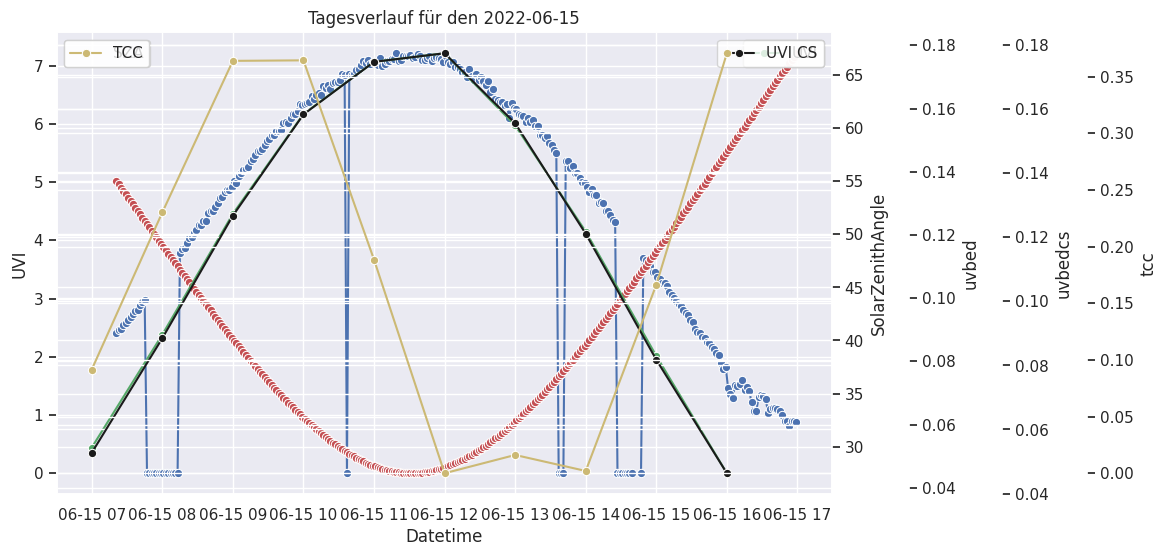

In [45]:
cols_to_plot = ['UVI', 'SolarZenithAngle', 'aod469', 'uvbed', 'uvbedcs', 'tcc']
create_daily_plots(df_plot_daily[0:300], cols_to_plot)

##

## Korrelation der Stündlichen Mittelwerte:

Berechnen der Varabilitätsindices Indizes:

In [61]:
df_corr_hour = pd.concat([df_UVI_hourly[['UVI', 'SolarZenithAngle']], df_CAMS[['aod469', 'aod550', 'hcc', 'mcc', 'lcc', 'tcc', 'uvbed', 'uvbedcs']]], axis = 1)

In [62]:
df_corr_hour

,UVI,SolarZenithAngle,aod469,aod550,hcc,mcc,lcc,tcc,uvbed,uvbedcs
Datetime,,,,,,,,,,
2022-06-15 07:00:00,2.686945,53.151062,0.152110,0.121109,0.091481,0.0,0.000000,0.091481,0.052725,0.052729
2022-06-15 08:00:00,4.378194,43.431673,0.162309,0.129266,0.230113,0.0,0.000000,0.230113,0.088452,0.088484
2022-06-15 09:00:00,5.684107,36.261871,0.170056,0.135440,0.363832,0.0,0.000000,0.363832,0.126678,0.126780
2022-06-15 10:00:00,6.736104,30.156914,0.176425,0.140516,0.364290,0.0,0.000000,0.364290,0.158258,0.158390
2022-06-15 11:00:00,7.114456,27.689482,0.180305,0.143640,0.188470,0.0,0.000000,0.188470,0.174792,0.174800
...,...,...,...,...,...,...,...,...,...,...
2023-05-26 05:00:00,0.453827,73.676475,0.439879,0.354388,0.000000,0.0,0.004669,0.004669,0.007166,0.007169
2023-05-26 06:00:00,1.170444,64.313051,0.424471,0.342194,0.000000,0.0,0.001877,0.001877,0.020354,0.020357
2023-05-26 07:00:00,2.363173,54.880384,0.402243,0.324256,0.000000,0.0,0.008515,0.008515,0.043894,0.043902


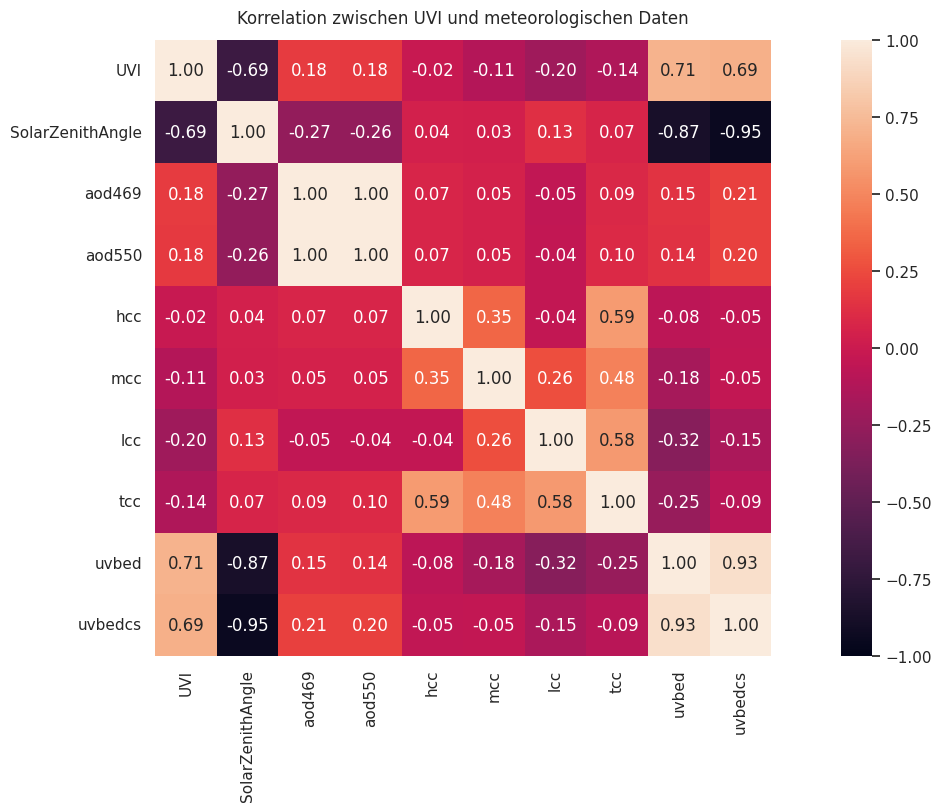

In [64]:
# Increase the size of the heatmap.
plt.figure(figsize=(18, 8))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_corr_hour.corr(), fmt='.2f', vmin=-1, vmax=1, annot=True, square=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Korrelation zwischen UVI und meteorologischen Daten', fontdict={'fontsize':12}, pad=12);

## Kreuzkorrelation der Messwerte und der Vorhersagewerte: